In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# K-Means
## Ivan Makaveev, 2MI0600203

In [12]:
file_path_unbalance = "./unbalance/unbalance.txt"
file_path_normal = "./normal/normal.txt"
file_path = file_path_unbalance
seed = 1337
np.random.seed(seed)

clusters = 8
restarts = 10

In [14]:
data = np.loadtxt(file_path)

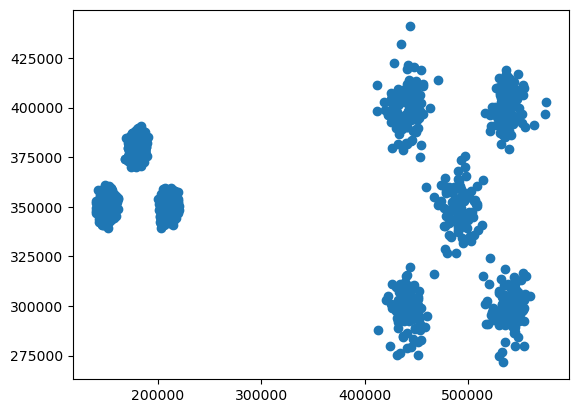

In [15]:
plt.scatter(data[:,0], data[:,1])
plt.show()

In [5]:
def wcss_metric(points, centroids, labels):
    return np.sum([np.linalg.norm(points[labels == i] - centroids[i]) for i in range(len(centroids))])

def silhouette_score(points, centroids, labels):
    results = list()
    for i, pt in enumerate(points):
        label = labels[i]
        average_in_cluster = np.mean(np.linalg.norm(points[labels==label] - pt, axis=1))
        min_average_between_clusters = np.inf;
        
        for k, centroid in enumerate(centroids):
            if k != label:
                other_points = points[labels==k]
                min_average_between_clusters = min(min_average_between_clusters, np.mean(np.linalg.norm(other_points - pt, axis=1)))
        
        a = average_in_cluster
        b = min_average_between_clusters
        results.append((b-a)/max(a,b))
        
    return np.mean(results)

def silhouette_metric(points, centroids, labels):
    return 1 / silhouette_score(points, centroids, labels)

In [6]:
class KMeans:
    def __init__(self, k_clusters, metric=None, restarts=1, random_selection="uniform"):
        if(k_clusters < 1):
            raise ValueError("Cluster count K must be at least 1")
        if(restarts < 1):
            raise ValueError("Restarts count must be at least 1")
        if(random_selection not in ("uniform", "from_data")):
            raise ValueError("Random selection must be either uniform or from_data")
        self.k = k_clusters
        self.metric = metric
        self.restarts = restarts
        self.random_selection = random_selection
        self.centroids = None
    
    def random_pick_centroids(self, points):
        return points[np.random.choice(len(points), self.k, replace=False)]
    
    def random_init_centroids(self, points):
        features = points.shape[1]
        centroids = np.random.rand(self.k, features)
        for i in range(features):
            min_coord = points[:,i].min()
            max_coord = points[:,i].max()
            centroids[:, i] = centroids[:, i] * (max_coord - min_coord) + min_coord
        return centroids
    
    def init_centroids_farthest(self, points):
        centroids = [points[np.random.choice(len(points))]]
        for _ in range(self.k - 1):
            dist = np.min(
                [np.sum((points - centroid) ** 2, axis=1) for centroid in centroids],
                axis=0
            )
            probs = dist / dist.sum()
            centroid_id = np.random.choice(len(points), p=probs)
            centroids.append(points[centroid_id])

        return np.array(centroids)
    
    def init_centroids(self, points):
        if(self.restarts == 1):
            return self.init_centroids_farthest(points)
        else:
            if(self.random_selection == "uniform"):
                return self.random_init_centroids(points)  
            elif(self.random_selection == "from_data"):
                return self.random_pick_centroids(points)
    
    def move_centroids(self, points, labels):
        centroids = []
        for i in range(self.k):
            cluster_points = points[labels == i]
            centroids.append(cluster_points.mean(axis=0))
        return np.array(centroids)
    
    def label_points(self, points, centroids):
        dist = np.linalg.norm(points[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(dist, axis=1)

        for i in range(self.k):
            if i not in labels:
                labels[np.random.choice(len(points))] = i

        return labels

    def train(self, points):
        best_centroids = None
        best_metric = np.inf
        for _ in range(self.restarts):
            centroids = self.init_centroids(points)
            point_labels = None
            while True:
                new_labels = self.label_points(points, centroids)
                if np.array_equal(point_labels, new_labels):
                    break
                point_labels = new_labels
                centroids = self.move_centroids(points, point_labels)
            
            if(self.restarts != 1):
                curr_metric = self.metric(points, centroids, point_labels)
                if(best_metric > curr_metric):
                    best_metric = curr_metric
                    best_centroids = centroids
            else:
                best_centroids = centroids
                    
        self.centroids = best_centroids
    
    def get_centroids(self):
        if(self.centroids is None):
            raise ValueError("KMeans model not trained")
            
        return self.centroids
    
    def predict(self, points):
        if(self.centroids is None):
            raise ValueError("KMeans model not trained")
            
        if(points.ndim == 1):
            dist = np.linalg.norm(points[None] - self.centroids, axis=1)
            label = np.argmin(dist, axis=0)
            return label
        elif(points.ndim == 2):
            dist = np.linalg.norm(points[:,None] - self.centroids[None,:], axis=2)
            labels = np.argmin(dist, axis=1)
            return labels

In [7]:
def plot_data_and_centroids(points, centroids, labels):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=labels, palette='Set1', s=100, legend='full')

    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=300, marker='X', label='Centroids')
    
    plt.title('Data and Centroids Visualization')
    plt.legend()
    plt.show()

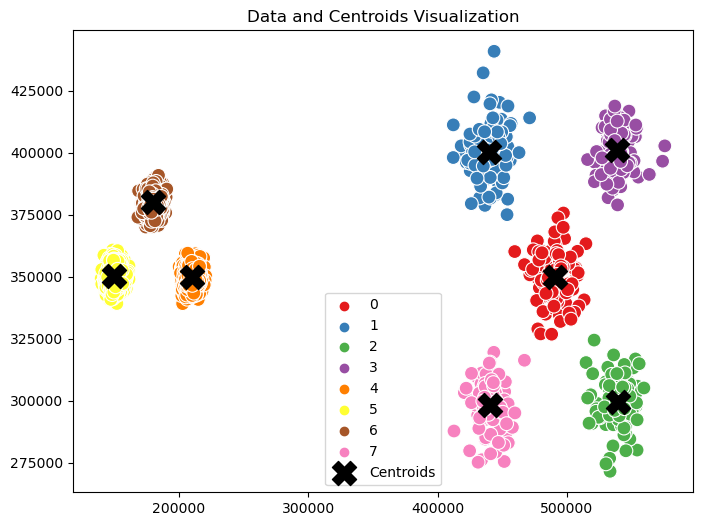

In [24]:
model = KMeans(clusters, wcss_metric, restarts, 'uniform')
model.train(data)
c = model.get_centroids()
plot_data_and_centroids(data, c, model.predict(data))

# Bonus: SoftKMeans

In [9]:
class SoftKMeans:
    def __init__(self, k_clusters, beta=1.0, metric=None, restarts=1, random_selection="uniform"):
        if(k_clusters < 1):
            raise ValueError("Cluster count K must be at least 1")
        if(restarts < 1):
            raise ValueError("Restarts count must be at least 1")
        if(random_selection not in ("uniform", "from_data")):
            raise ValueError("Random selection must be either uniform or from_data")
        if(beta <= 0):
            raise ValueError("Beta must be > 0")

        self.k = k_clusters
        self.beta = beta
        self.metric = metric
        self.restarts = restarts
        self.random_selection = random_selection

        self.centroids = None

    def random_pick_centroids(self, points):
        return points[np.random.choice(len(points), self.k, replace=False)]
    
    def random_init_centroids(self, points):
        features = points.shape[1]
        centroids = np.random.rand(self.k, features)
        for i in range(features):
            min_coord = points[:,i].min()
            max_coord = points[:,i].max()
            centroids[:, i] = centroids[:, i] * (max_coord - min_coord) + min_coord
        return centroids
    
    def init_centroids_farthest(self, points):
        centroids = [points[np.random.choice(len(points))]]
        for _ in range(self.k - 1):
            dist = np.min(
                [np.sum((points - centroid) ** 2, axis=1) for centroid in centroids],
                axis=0
            )
            probs = dist / dist.sum()
            centroid_id = np.random.choice(len(points), p=probs)
            centroids.append(points[centroid_id])

        return np.array(centroids)
    
    def init_centroids(self, points):
        if(self.restarts == 1):
            return self.init_centroids_farthest(points)
        else:
            if(self.random_selection == "uniform"):
                return self.random_init_centroids(points)  
            elif(self.random_selection == "from_data"):
                return self.random_pick_centroids(points)

    def dist(self, points, centroids):
        diff = points[:, None, :] - centroids[None, :, :]
        return np.sum(diff * diff, axis=2)

    def responsibilities(self, points, centroids):
        d2 = self.dist(points, centroids)
        power = -self.beta * d2

        shift_power = power - np.max(power, axis=1, keepdims=True)
        weights = np.exp(shift_power)
        weights_sum = np.sum(weights, axis=1, keepdims=True)
        return weights / weights_sum

    def move_centroids(self, points, resp):
        sum_of_resp_per_cluster = np.sum(resp, axis=0)
        centroids = (resp.T @ points) / sum_of_resp_per_cluster[:, None] 

        return centroids

    def label_points(self, points, centroids):
        R = self.responsibilities(points, centroids)
        return np.argmax(R, axis=1)

    def train(self, points, max_iter=300, tolerance=1e-6):
        best_centroids = None
        best_metric = np.inf

        for _ in range(self.restarts):
            centroids = self.init_centroids(points)

            for _ in range(max_iter):
                resp = self.responsibilities(points, centroids)
                new_centroids = self.move_centroids(points, resp)

                shift = np.linalg.norm(new_centroids - centroids)
                centroids = new_centroids
                if(shift < tolerance):
                    break

            point_labels = np.argmax(self.responsibilities(points, centroids), axis=1)

            if(self.restarts != 1):
                curr_metric = self.metric(points, centroids, point_labels)
                if(best_metric > curr_metric):
                    best_metric = curr_metric
                    best_centroids = centroids
            else:
                best_centroids = centroids

        self.centroids = best_centroids

    def get_centroids(self):
        if self.centroids is None:
            raise ValueError("SoftKMeans model not trained")
        return self.centroids

    def predict_probs(self, points):
        if self.centroids is None:
            raise ValueError("SoftKMeans model not trained")

        if(points.ndim == 1):
            R = self.responsibilities(points[None, :], self.centroids)
            return R[0]
        elif(points.ndim == 2):
            return self.responsibilities(points, self.centroids)

    def predict(self, points):
        probs = self.predict_probs(points)
        if(probs.ndim == 1):
            return int(np.argmax(probs))
        elif(probs.ndim == 2):
            return np.argmax(probs, axis=1)

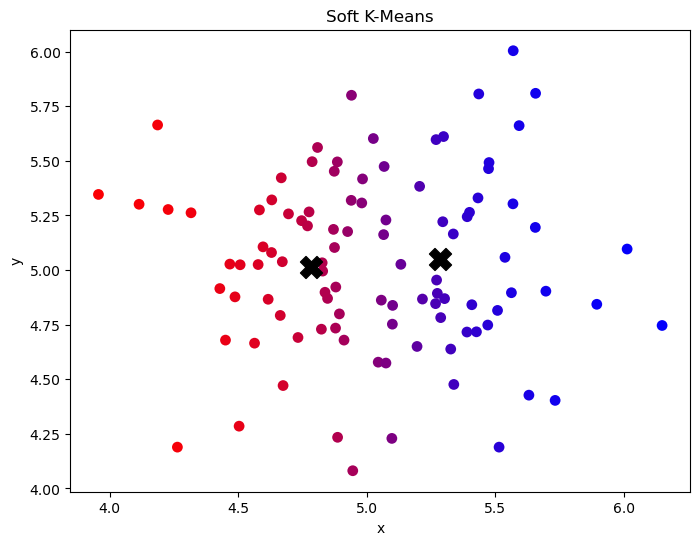

In [10]:
data = np.loadtxt(file_path_normal)
model2 = SoftKMeans(2, 4.0, wcss_metric, 10, 'uniform')
model2.train(data)
c = model2.get_centroids()
resp = model2.predict_probs(data)

first_color = np.array([1.0, 0.0, 0.0])
second_color = np.array([0.0, 0.0, 1.0])
point_colors = resp[:, [0]] * first_color + resp[:, [1]] * second_color

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=point_colors, s=60, edgecolors="none")
plt.scatter(c[:, 0], c[:, 1], c="black", marker="X", s=250)

plt.title("Soft K-Means")
plt.xlabel("x")
plt.ylabel("y")
plt.show()